# Mounting Drive

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import tensorflow as tf
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


# Importing Dependencies

In [3]:
import os
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from tensorflow import keras
import cv2
from tqdm import tqdm

# Understanding the Data

In [4]:
path = os.path.join(os.getcwd(), '/content')
train_path = os.path.join(path, '/content/drive/MyDrive/Colab_Notebooks/BreaKHis_400X/train/')
val_path = os.path.join(path, '/content/drive/MyDrive/Colab_Notebooks/BreaKHis_400X/test')

In [5]:
#Getting class labels

class_labels = []

for dir in os.listdir(train_path):
    class_labels.append(dir)

class_labels

['malignant', 'benign']

In [6]:
number_of_images_per_category = {}

for cat in os.listdir(train_path):
    number_of_images_per_category[cat] = len(os.listdir(os.path.join(train_path, cat)))

number_of_images_per_category    

{'malignant': 780, 'benign': 752}

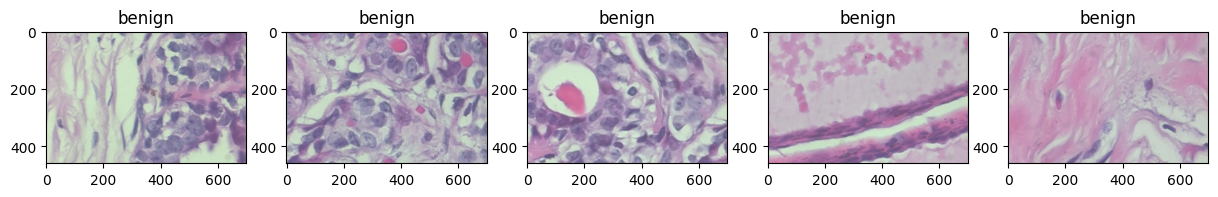

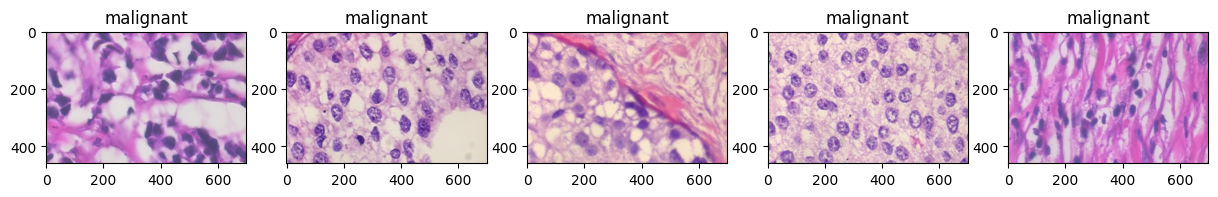

In [7]:
def plot_images(folder_path, label):
    fig, axs = plt.subplots(1, 5, figsize=(15, 3))
    [axs[i].imshow(plt.imread(os.path.join(folder_path, file))) for i, file in enumerate(os.listdir(folder_path)[:5])]
    [axs[i].set_title(label) for i in range(5)]
    plt.show()

benign_path = "/content/drive/MyDrive/Colab_Notebooks/BreaKHis_400X/train/benign"
plot_images(benign_path, "benign")
malignant_path = "/content/drive/MyDrive/Colab_Notebooks/BreaKHis_400X/train/malignant"
plot_images(malignant_path, "malignant")


# Loading Data and Augmentation

In [8]:
from keras.preprocessing.image import ImageDataGenerator

In [9]:
img_size = 224
batch_size = 32

In [10]:
train_datagen = ImageDataGenerator(
    rescale = 1./255,
    rotation_range = 30,
    shear_range = 0.3,
    zoom_range = 0.3,
    width_shift_range = 0.4,
    height_shift_range = 0.4,
    horizontal_flip = True,
    fill_mode = 'nearest'
)

In [11]:
validation_datagen = ImageDataGenerator(
    rescale=1./255
)

In [12]:
train_generator = train_datagen.flow_from_directory(
    train_path,
    target_size=(img_size, img_size),
    batch_size=batch_size,
    class_mode='binary',
    color_mode='rgb',
)

val_generator = validation_datagen.flow_from_directory(
    val_path,
    target_size=(img_size, img_size),
    batch_size=batch_size,
    class_mode='binary',
    color_mode='rgb',
)

Found 1531 images belonging to 2 classes.
Found 559 images belonging to 2 classes.


In [13]:
# Get class indices and names
class_indices = train_generator.class_indices
class_names = list(class_indices.keys())

# Iterate over classes and count number of images
for class_name in class_names:
    class_dir = os.path.join(train_generator.directory, class_name)
    num_images = len(os.listdir(class_dir))
    print(f"{class_name}: {num_images} images")

benign: 752 images
malignant: 780 images


In [14]:
len(train_generator)

48

In [15]:
# !pip install Augmentor
# path_to_augment  = "/content/drive/MyDrive/Colab_Notebooks/BreaKHis_400X/train/benign"

In [16]:
# class_indices = train_generator.class_indices
# class_names = list(class_indices.keys())

# import Augmentor
# p = Augmentor.Pipeline(path_to_augment)
# p.rotate(probability=0.9, max_left_rotation=25, max_right_rotation=25)
# p.sample(370) ## We are adding 370 samples per class to make sure that none of the classes are sparse.

In [17]:
# path =  "/content/drive/MyDrive/Colab_Notebooks/BreaKHis_400X/train/benign/"
# os.path.join("/content/drive/MyDrive/Colab_Notebooks/BreaKHis_400X/train/benign/","output/")

In [18]:
# len(os.listdir("/content/drive/MyDrive/Colab_Notebooks/BreaKHis_400X/train/benign"))

In [19]:
# files  = os.listdir("/content/drive/MyDrive/Colab_Notebooks/BreaKHis_400X/train/benign/output")
# files

In [20]:
# import shutil

# for i, filename in enumerate(files):
#   org = os.path.join("/content/drive/MyDrive/Colab_Notebooks/BreaKHis_400X/train/benign/","output/"+filename)
#   tgt = os.path.join("/content/drive/MyDrive/Colab_Notebooks/BreaKHis_400X/train/benign")
#   shutil.move(org,tgt)

In [21]:
# !cp /content/drive/MyDrive/Colab Notebooks/BreaKHis_400X/train/benign/output/benign_original_SOB_B_A-14-22549AB-400-006.png_1d88684b-4c3f-40ed-8ee5-3f4b3d905fe5.png /content/drive/MyDrive/Colab Notebooks/BreaKHis_400X/train/benign

# Model

In [22]:
from keras.models import Sequential
from keras import layers
from keras.layers import Conv2D, MaxPooling2D, Flatten,Dense,Dropout,BatchNormalization
from keras import regularizers
from tensorflow.keras.optimizers import Adam,RMSprop,SGD,Adamax
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

## RESNET152V2

In [23]:
resnet152v2_base = tf.keras.applications.resnet_v2.ResNet152V2(
    include_top=False,
    weights="imagenet",
    input_tensor=None,
    input_shape=(224,224,3),
    pooling=None,
    classes=1000,
    classifier_activation="softmax",
)

234545216/234545216 [==============================] - 11s 0us/step


In [24]:
# resnet152v2_base.summary()

In [25]:
resnet152v2_model = Sequential()
resnet152v2_model.add(resnet152v2_base)
resnet152v2_model.add(Flatten())
resnet152v2_model.add(BatchNormalization())
resnet152v2_model.add(Dense(1024, activation='relu'))
resnet152v2_model.add(Dropout(0.4))
resnet152v2_model.add(Dense(256, activation='relu'))
resnet152v2_model.add(Dropout(0.4))
resnet152v2_model.add(BatchNormalization())
resnet152v2_model.add(Dense(1, activation='sigmoid'))


In [26]:
resnet152v2_base.trainable = False

In [27]:
resnet152v2_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet152v2 (Functional)    (None, 7, 7, 2048)        58331648  
                                                                 
 flatten (Flatten)           (None, 100352)            0         
                                                                 
 batch_normalization (BatchN  (None, 100352)           401408    
 ormalization)                                                   
                                                                 
 dense (Dense)               (None, 1024)              102761472 
                                                                 
 dropout (Dropout)           (None, 1024)              0         
                                                                 
 dense_1 (Dense)             (None, 256)               262400    
                                                        

In [28]:
optimizer = tf.keras.optimizers.Adam(learning_rate=0.0003)
resnet152v2_model.compile(optimizer = optimizer, loss = 'binary_crossentropy', metrics = ['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall(), tf.keras.metrics.AUC()])

In [29]:
resnet152v2_history = resnet152v2_model.fit(train_generator, epochs=30, validation_data=val_generator)

Epoch 1/30
48/48 [==============================] - 926s 19s/step - loss: 0.6714 - accuracy: 0.6708 - precision: 0.6802 - recall: 0.6679 - auc: 0.7364 - val_loss: 0.6632 - val_accuracy: 0.7782 - val_precision: 0.7891 - val_recall: 0.9182 - val_auc: 0.8282
Epoch 2/30
48/48 [==============================] - 52s 1s/step - loss: 0.5672 - accuracy: 0.7348 - precision: 0.7448 - recall: 0.7295 - auc: 0.8068 - val_loss: 0.5054 - val_accuracy: 0.8211 - val_precision: 0.8974 - val_recall: 0.8311 - val_auc: 0.8737
Epoch 3/30
48/48 [==============================] - 52s 1s/step - loss: 0.5206 - accuracy: 0.7479 - precision: 0.7487 - recall: 0.7603 - auc: 0.8358 - val_loss: 0.4471 - val_accuracy: 0.8462 - val_precision: 0.8970 - val_recall: 0.8734 - val_auc: 0.8898
Epoch 4/30
48/48 [==============================] - 52s 1s/step - loss: 0.5043 - accuracy: 0.7727 - precision: 0.7714 - recall: 0.7872 - auc: 0.8508 - val_loss: 0.4454 - val_accuracy: 0.8497 - val_precision: 0.9063 - val_recall: 0.8681 

dict_keys(['loss', 'accuracy', 'precision', 'recall', 'auc', 'val_loss', 'val_accuracy', 'val_precision', 'val_recall', 'val_auc'])


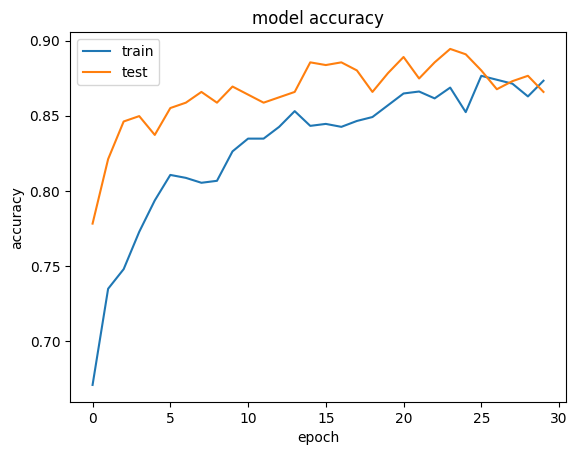

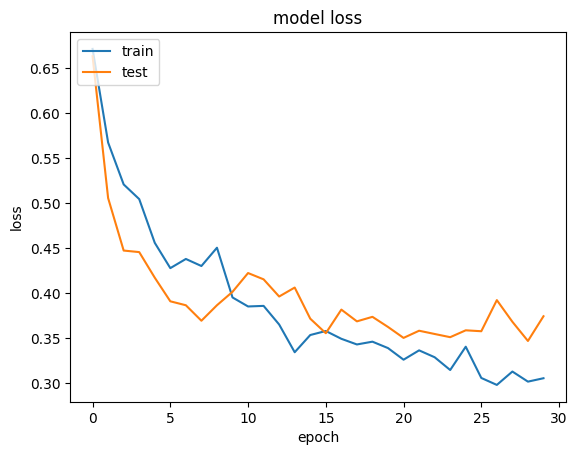

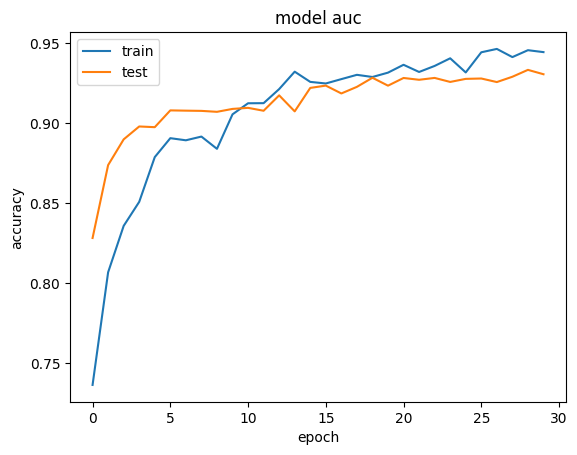

In [30]:
print(resnet152v2_history.history.keys())
# summarize history for accuracy
plt.plot(resnet152v2_history.history['accuracy'])
plt.plot(resnet152v2_history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(resnet152v2_history.history['loss'])
plt.plot(resnet152v2_history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# summarize history for auc
plt.plot(resnet152v2_history.history['auc'])
plt.plot(resnet152v2_history.history['val_auc'])
plt.title('model auc')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()


In [31]:
# yp = resnet152v2_model.predict(val_generator)

In [32]:
# len(val_generator) * len(val_generator[0][0])

In [33]:
# y_pred = []
# y_true = []

# for i in range(len(val_generator)):
#   images,labels = val_generator[i]
#   ypreds = resnet152v2_model.predict(images).squeeze(1)
#   ypreds = np.round(ypreds)
#   y_pred.extend(ypreds)
#   y_true.extend(labels)

In [34]:
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, f1_score

y_pred = []
y_true = []

for i in range(len(val_generator)):
  images,labels = val_generator[i]
  ypreds = resnet152v2_model.predict(images,verbose=0).squeeze(1)
  ypreds = np.round(ypreds)
  y_pred.extend(ypreds)
  y_true.extend(labels)


cm = confusion_matrix(y_true, y_pred)
print("Confusion matrix:\n", cm)
cr = classification_report(y_true, y_pred)
print("Classification report:\n", cr)
acc = accuracy_score(y_true, y_pred)
print("Accuracy:", acc)
f1 = f1_score(y_true, y_pred)
print("F1-score:", f1)

Confusion matrix:
 [[154  26]
 [ 49 330]]
Classification report:
               precision    recall  f1-score   support

         0.0       0.76      0.86      0.80       180
         1.0       0.93      0.87      0.90       379

    accuracy                           0.87       559
   macro avg       0.84      0.86      0.85       559
weighted avg       0.87      0.87      0.87       559

Accuracy: 0.8658318425760286
F1-score: 0.8979591836734694


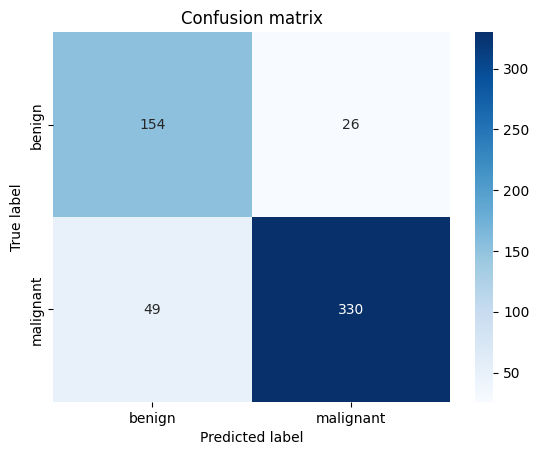

In [35]:
import seaborn as sns

# Plot the confusion matrix
sns.heatmap(cm, annot=True, cmap="Blues", fmt="d", xticklabels=['benign', 'malignant'], yticklabels=['benign', 'malignant'])
plt.title('Confusion matrix')
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

## DENSENET201

In [36]:
densenet201_base = tf.keras.applications.DenseNet201(
    weights='imagenet',
    include_top=False,
    input_shape=(224, 224, 3)
)

74836368/74836368 [==============================] - 4s 0us/step


In [37]:
densenet201_model = Sequential()
densenet201_model.add(densenet201_base)
densenet201_model.add(Conv2D(16, (3, 3), padding="valid", activation="relu"))
densenet201_model.add(MaxPooling2D(pool_size=(2, 2), strides=(1, 1), padding="same"))
densenet201_model.add(Conv2D(32, (3, 3), padding="valid", activation="relu"))
densenet201_model.add(MaxPooling2D(pool_size=(2, 2), strides=(1, 1), padding="same"))
densenet201_model.add(Conv2D(64, (3, 3), padding="valid", activation="relu"))
densenet201_model.add(MaxPooling2D(pool_size=(2, 2), strides=(1, 1), padding="same"))
densenet201_model.add(Flatten())
densenet201_model.add(layers.Dropout(0.5))
densenet201_model.add(layers.BatchNormalization())
densenet201_model.add(layers.Dense(1, activation='sigmoid'))

In [38]:
densenet201_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 densenet201 (Functional)    (None, 7, 7, 1920)        18321984  
                                                                 
 conv2d (Conv2D)             (None, 5, 5, 16)          276496    
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 5, 5, 16)         0         
 2D)                                                             
                                                                 
 conv2d_1 (Conv2D)           (None, 3, 3, 32)          4640      
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 3, 3, 32)         0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 1, 1, 64)         

In [39]:
densenet201_base.trainable = False

In [40]:
optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001)
densenet201_model.compile(optimizer = optimizer, loss = 'binary_crossentropy', metrics = ['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall(), tf.keras.metrics.AUC()])

In [41]:
densenet201_history = densenet201_model.fit(train_generator, epochs=30, validation_data=val_generator)

Epoch 1/30
48/48 [==============================] - 78s 1s/step - loss: 0.7550 - accuracy: 0.5663 - precision_1: 0.5810 - recall_1: 0.5333 - auc_1: 0.5782 - val_loss: 0.6164 - val_accuracy: 0.6905 - val_precision_1: 0.6886 - val_recall_1: 0.9921 - val_auc_1: 0.6314
Epoch 2/30
48/48 [==============================] - 50s 1s/step - loss: 0.6954 - accuracy: 0.6101 - precision_1: 0.6252 - recall_1: 0.5859 - auc_1: 0.6454 - val_loss: 0.5634 - val_accuracy: 0.7030 - val_precision_1: 0.7252 - val_recall_1: 0.9050 - val_auc_1: 0.7126
Epoch 3/30
48/48 [==============================] - 51s 1s/step - loss: 0.6258 - accuracy: 0.6604 - precision_1: 0.6821 - recall_1: 0.6244 - auc_1: 0.7260 - val_loss: 0.5275 - val_accuracy: 0.7299 - val_precision_1: 0.7395 - val_recall_1: 0.9288 - val_auc_1: 0.7668
Epoch 4/30
48/48 [==============================] - 51s 1s/step - loss: 0.5439 - accuracy: 0.7263 - precision_1: 0.7546 - recall_1: 0.6859 - auc_1: 0.8018 - val_loss: 0.5005 - val_accuracy: 0.7710 - val

dict_keys(['loss', 'accuracy', 'precision_1', 'recall_1', 'auc_1', 'val_loss', 'val_accuracy', 'val_precision_1', 'val_recall_1', 'val_auc_1'])


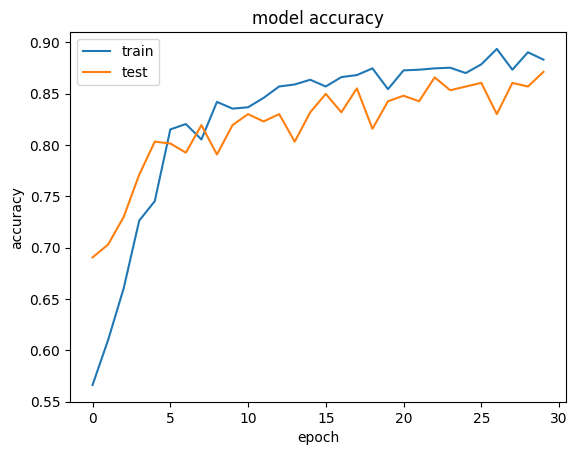

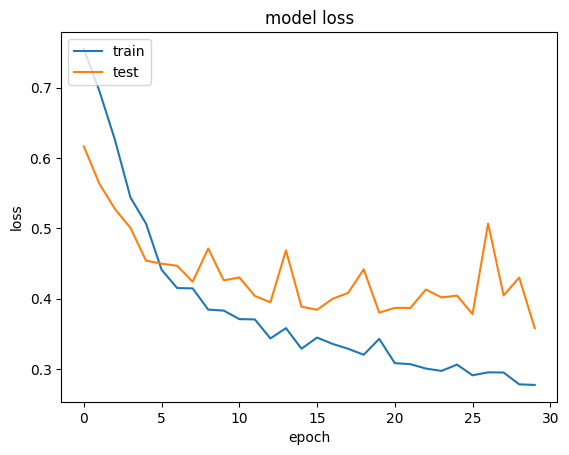

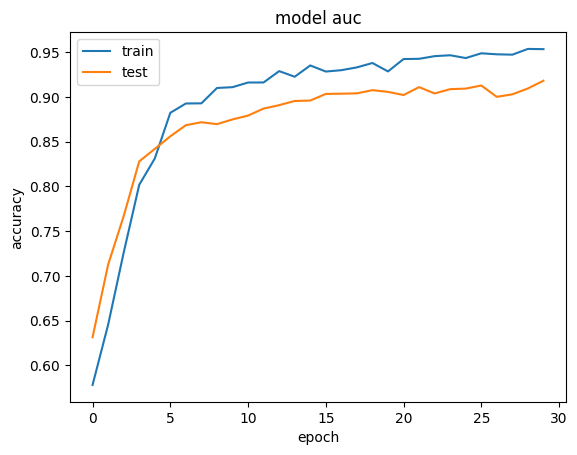

In [42]:
print(densenet201_history.history.keys())
# summarize history for accuracy
plt.plot(densenet201_history.history['accuracy'])
plt.plot(densenet201_history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(densenet201_history.history['loss'])
plt.plot(densenet201_history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# summarize history for auc
plt.plot(densenet201_history.history['auc_1'])
plt.plot(densenet201_history.history['val_auc_1'])
plt.title('model auc')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()


In [43]:
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, f1_score

y_pred = []
y_true = []

for i in range(len(val_generator)):
  images,labels = val_generator[i]
  ypreds = densenet201_model.predict(images,verbose=0).squeeze(1)
  ypreds = np.round(ypreds)
  y_pred.extend(ypreds)
  y_true.extend(labels)


cm = confusion_matrix(y_true, y_pred)
print("Confusion matrix:\n", cm)
cr = classification_report(y_true, y_pred)
print("Classification report:\n", cr)
acc = accuracy_score(y_true, y_pred)
print("Accuracy:", acc)
f1 = f1_score(y_true, y_pred)
print("F1-score:", f1)

Confusion matrix:
 [[136  44]
 [ 28 351]]
Classification report:
               precision    recall  f1-score   support

         0.0       0.83      0.76      0.79       180
         1.0       0.89      0.93      0.91       379

    accuracy                           0.87       559
   macro avg       0.86      0.84      0.85       559
weighted avg       0.87      0.87      0.87       559

Accuracy: 0.8711985688729875
F1-score: 0.9069767441860466


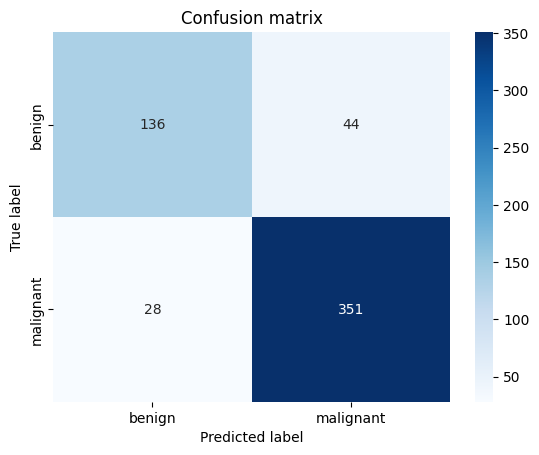

In [44]:
import seaborn as sns

# Plot the confusion matrix
sns.heatmap(cm, annot=True, cmap="Blues", fmt="d", xticklabels=['benign', 'malignant'], yticklabels=['benign', 'malignant'])
plt.title('Confusion matrix')
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

## VGG16

In [45]:
vgg16_base = tf.keras.applications.vgg16.VGG16(
    weights = 'imagenet',
    include_top = False,
    input_shape = (img_size, img_size, 3)
)

58889256/58889256 [==============================] - 3s 0us/step


In [46]:
vgg_model = Sequential()
vgg_model.add(vgg16_base)
vgg_model.add(Flatten())
vgg_model.add(Dense(512, activation = 'relu'))
vgg_model.add(Dropout(0.3))
vgg_model.add(Dense(256, activation = 'relu'))
vgg_model.add(Dropout(0.3))
vgg_model.add(Dense(1, activation = 'sigmoid'))

In [47]:
vgg_model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 flatten_2 (Flatten)         (None, 25088)             0         
                                                                 
 dense_4 (Dense)             (None, 512)               12845568  
                                                                 
 dropout_3 (Dropout)         (None, 512)               0         
                                                                 
 dense_5 (Dense)             (None, 256)               131328    
                                                                 
 dropout_4 (Dropout)         (None, 256)               0         
                                                                 
 dense_6 (Dense)             (None, 1)                

In [48]:
vgg16_base.trainable = False

In [49]:
optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001)
vgg_model.compile(optimizer = optimizer, loss = 'binary_crossentropy', metrics = ['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall(), tf.keras.metrics.AUC()])

In [50]:
vgg_history = vgg_model.fit(train_generator, epochs = 30, validation_data = val_generator)

Epoch 1/30
48/48 [==============================] - 61s 1s/step - loss: 0.7194 - accuracy: 0.5591 - precision_2: 0.5652 - recall_2: 0.5833 - auc_2: 0.5882 - val_loss: 0.5535 - val_accuracy: 0.7120 - val_precision_2: 0.7041 - val_recall_2: 0.9921 - val_auc_2: 0.7826
Epoch 2/30
48/48 [==============================] - 49s 1s/step - loss: 0.6335 - accuracy: 0.6492 - precision_2: 0.6487 - recall_2: 0.6795 - auc_2: 0.7015 - val_loss: 0.6138 - val_accuracy: 0.6673 - val_precision_2: 0.9142 - val_recall_2: 0.5620 - val_auc_2: 0.8195
Epoch 3/30
48/48 [==============================] - 48s 1s/step - loss: 0.6080 - accuracy: 0.6793 - precision_2: 0.6831 - recall_2: 0.6910 - auc_2: 0.7341 - val_loss: 0.4782 - val_accuracy: 0.7746 - val_precision_2: 0.7720 - val_recall_2: 0.9472 - val_auc_2: 0.8427
Epoch 4/30
48/48 [==============================] - 50s 1s/step - loss: 0.5491 - accuracy: 0.7283 - precision_2: 0.7321 - recall_2: 0.7359 - auc_2: 0.7965 - val_loss: 0.4561 - val_accuracy: 0.7746 - val

dict_keys(['loss', 'accuracy', 'precision_2', 'recall_2', 'auc_2', 'val_loss', 'val_accuracy', 'val_precision_2', 'val_recall_2', 'val_auc_2'])


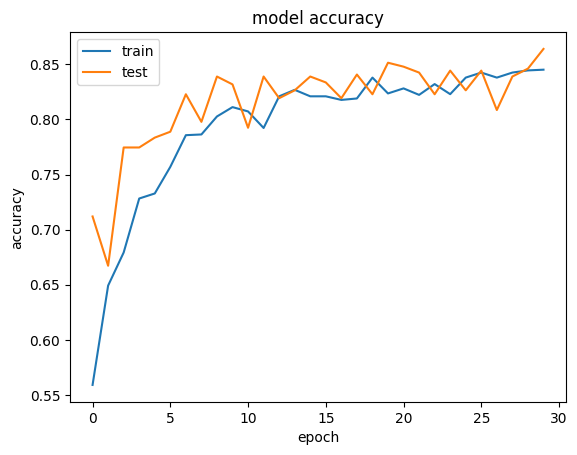

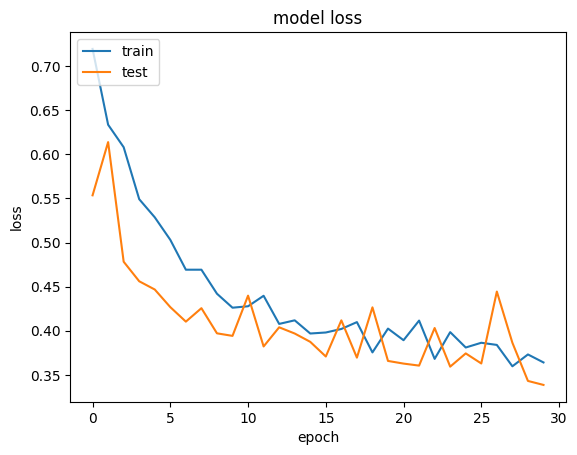

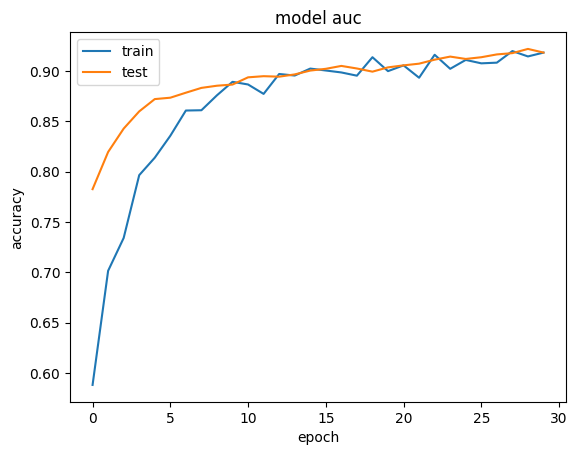

In [51]:
print(vgg_history.history.keys())
# summarize history for accuracy
plt.plot(vgg_history.history['accuracy'])
plt.plot(vgg_history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(vgg_history.history['loss'])
plt.plot(vgg_history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# summarize history for auc
plt.plot(vgg_history.history['auc_2'])
plt.plot(vgg_history.history['val_auc_2'])
plt.title('model auc')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [52]:
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, f1_score

y_pred = []
y_true = []

for i in range(len(val_generator)):
  images,labels = val_generator[i]
  ypreds = vgg_model.predict(images,verbose=0).squeeze(1)
  ypreds = np.round(ypreds)
  y_pred.extend(ypreds)
  y_true.extend(labels)


cm = confusion_matrix(y_true, y_pred)
print("Confusion matrix:\n", cm)
cr = classification_report(y_true, y_pred)
print("Classification report:\n", cr)
acc = accuracy_score(y_true, y_pred)
print("Accuracy:", acc)
f1 = f1_score(y_true, y_pred)
print("F1-score:", f1)

Confusion matrix:
 [[142  38]
 [ 38 341]]
Classification report:
               precision    recall  f1-score   support

         0.0       0.79      0.79      0.79       180
         1.0       0.90      0.90      0.90       379

    accuracy                           0.86       559
   macro avg       0.84      0.84      0.84       559
weighted avg       0.86      0.86      0.86       559

Accuracy: 0.8640429338103757
F1-score: 0.899736147757256


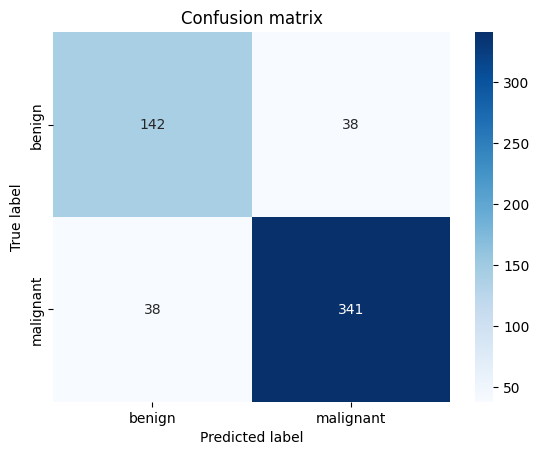

In [53]:
import seaborn as sns

# Plot the confusion matrix
sns.heatmap(cm, annot=True, cmap="Blues", fmt="d", xticklabels=['benign', 'malignant'], yticklabels=['benign', 'malignant'])
plt.title('Confusion matrix')
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

## Xception

In [54]:
xception_base = tf.keras.applications.Xception(
    weights = 'imagenet',
    include_top = False,
    input_shape = (img_size, img_size, 3)
)

83683744/83683744 [==============================] - 5s 0us/step


In [55]:
xception_model = Sequential()
xception_model.add(xception_base)
xception_model.add(Flatten())
xception_model.add(Dense(512, activation = 'relu'))
xception_model.add(Dropout(0.3))
xception_model.add(Dense(256, activation = 'relu'))
xception_model.add(Dropout(0.3))
xception_model.add(Dense(1, activation = 'sigmoid'))

In [56]:
xception_base.trainable = False

In [57]:
xception_model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 xception (Functional)       (None, 7, 7, 2048)        20861480  
                                                                 
 flatten_3 (Flatten)         (None, 100352)            0         
                                                                 
 dense_7 (Dense)             (None, 512)               51380736  
                                                                 
 dropout_5 (Dropout)         (None, 512)               0         
                                                                 
 dense_8 (Dense)             (None, 256)               131328    
                                                                 
 dropout_6 (Dropout)         (None, 256)               0         
                                                                 
 dense_9 (Dense)             (None, 1)                

In [58]:
optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001)
xception_model.compile(optimizer = optimizer, loss = 'binary_crossentropy', metrics = ['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall(), tf.keras.metrics.AUC()])

In [59]:
xception_history = xception_model.fit(train_generator, epochs = 30, validation_data = val_generator)

Epoch 1/30
48/48 [==============================] - 58s 1s/step - loss: 0.8004 - accuracy: 0.6238 - precision_3: 0.6335 - recall_3: 0.6205 - auc_3: 0.6681 - val_loss: 0.5216 - val_accuracy: 0.7549 - val_precision_3: 0.8071 - val_recall_3: 0.8391 - val_auc_3: 0.7901
Epoch 2/30
48/48 [==============================] - 49s 1s/step - loss: 0.6613 - accuracy: 0.6780 - precision_3: 0.6896 - recall_3: 0.6692 - auc_3: 0.7360 - val_loss: 0.5290 - val_accuracy: 0.7496 - val_precision_3: 0.8424 - val_recall_3: 0.7757 - val_auc_3: 0.8063
Epoch 3/30
48/48 [==============================] - 49s 1s/step - loss: 0.6018 - accuracy: 0.6976 - precision_3: 0.7056 - recall_3: 0.6974 - auc_3: 0.7646 - val_loss: 0.5261 - val_accuracy: 0.7460 - val_precision_3: 0.8319 - val_recall_3: 0.7836 - val_auc_3: 0.7960
Epoch 4/30
48/48 [==============================] - 50s 1s/step - loss: 0.5788 - accuracy: 0.7093 - precision_3: 0.7118 - recall_3: 0.7218 - auc_3: 0.7794 - val_loss: 0.5344 - val_accuracy: 0.7156 - val

dict_keys(['loss', 'accuracy', 'precision_3', 'recall_3', 'auc_3', 'val_loss', 'val_accuracy', 'val_precision_3', 'val_recall_3', 'val_auc_3'])


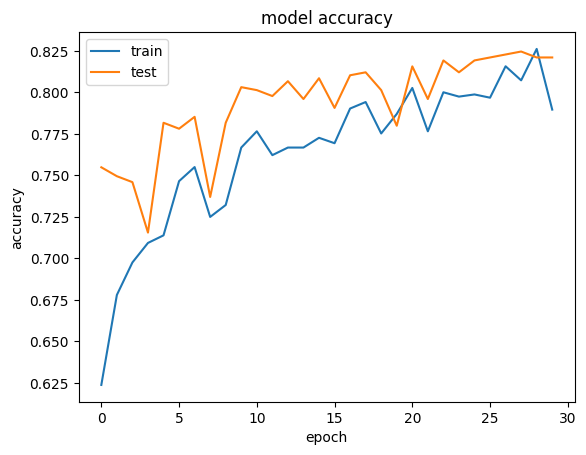

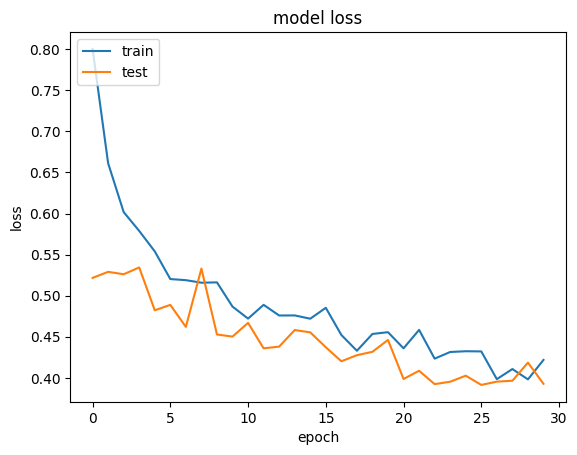

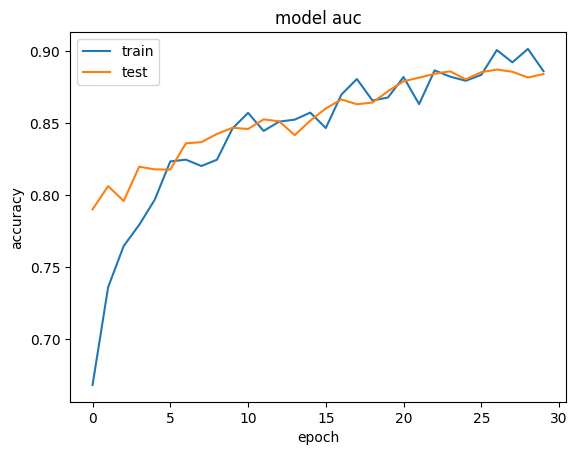

In [60]:
print(xception_history.history.keys())
# summarize history for accuracy
plt.plot(xception_history.history['accuracy'])
plt.plot(xception_history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(xception_history.history['loss'])
plt.plot(xception_history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# summarize history for auc
plt.plot(xception_history.history['auc_3'])
plt.plot(xception_history.history['val_auc_3'])
plt.title('model auc')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [75]:
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, f1_score

y_pred = []
y_true = []

for i in range(len(val_generator)):
  images,labels = val_generator[i]
  ypreds = xception_model.predict(images,verbose=0).squeeze(1)
  ypreds = np.round(ypreds)
  y_pred.extend(ypreds)
  y_true.extend(labels)


cm = confusion_matrix(y_true, y_pred)
print("Confusion matrix:\n", cm)
cr = classification_report(y_true, y_pred)
print("Classification report:\n", cr)
acc = accuracy_score(y_true, y_pred)
print("Accuracy:", acc)
f1 = f1_score(y_true, y_pred)
print("F1-score:", f1)

Confusion matrix:
 [[127  53]
 [ 47 332]]
Classification report:
               precision    recall  f1-score   support

         0.0       0.73      0.71      0.72       180
         1.0       0.86      0.88      0.87       379

    accuracy                           0.82       559
   macro avg       0.80      0.79      0.79       559
weighted avg       0.82      0.82      0.82       559

Accuracy: 0.8211091234347049
F1-score: 0.8691099476439791


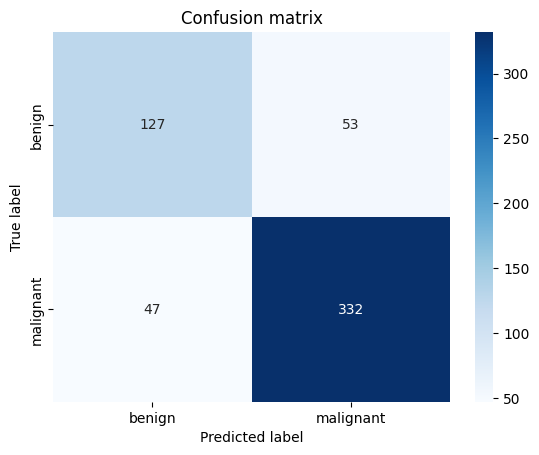

In [76]:
import seaborn as sns

# Plot the confusion matrix
sns.heatmap(cm, annot=True, cmap="Blues", fmt="d", xticklabels=['benign', 'malignant'], yticklabels=['benign', 'malignant'])
plt.title('Confusion matrix')
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

## InceptionResNetV2

In [98]:
InceptionResNetV2_base = tf.keras.applications.InceptionResNetV2(
    include_top=False,
    weights="imagenet",
    input_tensor=None,
    input_shape=(224,224,3),
    pooling=None,
    classes=1000,
    classifier_activation="softmax",
)

In [99]:
InceptionResNetV2_model = Sequential()
InceptionResNetV2_model.add(InceptionResNetV2_base)
InceptionResNetV2_model.add(Flatten())
InceptionResNetV2_model.add(BatchNormalization())
InceptionResNetV2_model.add(Dense(1024, activation='relu'))
InceptionResNetV2_model.add(Dropout(0.4))
InceptionResNetV2_model.add(Dense(256, activation='relu'))
InceptionResNetV2_model.add(Dropout(0.4))
InceptionResNetV2_model.add(BatchNormalization())
InceptionResNetV2_model.add(Dense(1, activation='sigmoid'))

In [100]:
InceptionResNetV2_base.trainable = False

In [101]:
InceptionResNetV2_model.summary()

Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inception_resnet_v2 (Functi  (None, 5, 5, 1536)       54336736  
 onal)                                                           
                                                                 
 flatten_9 (Flatten)         (None, 38400)             0         
                                                                 
 batch_normalization_826 (Ba  (None, 38400)            153600    
 tchNormalization)                                               
                                                                 
 dense_20 (Dense)            (None, 1024)              39322624  
                                                                 
 dropout_11 (Dropout)        (None, 1024)              0         
                                                                 
 dense_21 (Dense)            (None, 256)             

In [102]:
optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001)
InceptionResNetV2_model.compile(optimizer = optimizer, loss = 'binary_crossentropy', metrics = ['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall(), tf.keras.metrics.AUC()])

In [103]:
InceptionResNetV2_history = InceptionResNetV2_model.fit(train_generator, epochs = 30, validation_data = val_generator)

Epoch 1/30
48/48 [==============================] - 71s 1s/step - loss: 0.7315 - accuracy: 0.6532 - precision_6: 0.6632 - recall_6: 0.6487 - auc_6: 0.6973 - val_loss: 0.6331 - val_accuracy: 0.7335 - val_precision_6: 0.7533 - val_recall_6: 0.9024 - val_auc_6: 0.7362
Epoch 2/30
48/48 [==============================] - 52s 1s/step - loss: 0.6348 - accuracy: 0.6963 - precision_6: 0.7120 - recall_6: 0.6782 - auc_6: 0.7593 - val_loss: 0.5020 - val_accuracy: 0.7728 - val_precision_6: 0.8029 - val_recall_6: 0.8813 - val_auc_6: 0.8094
Epoch 3/30
48/48 [==============================] - 52s 1s/step - loss: 0.5926 - accuracy: 0.7087 - precision_6: 0.7186 - recall_6: 0.7038 - auc_6: 0.7840 - val_loss: 0.5142 - val_accuracy: 0.7835 - val_precision_6: 0.8728 - val_recall_6: 0.7968 - val_auc_6: 0.8276
Epoch 4/30
48/48 [==============================] - 50s 1s/step - loss: 0.5934 - accuracy: 0.7191 - precision_6: 0.7291 - recall_6: 0.7141 - auc_6: 0.7917 - val_loss: 0.4889 - val_accuracy: 0.7835 - val

dict_keys(['loss', 'accuracy', 'precision_6', 'recall_6', 'auc_6', 'val_loss', 'val_accuracy', 'val_precision_6', 'val_recall_6', 'val_auc_6'])


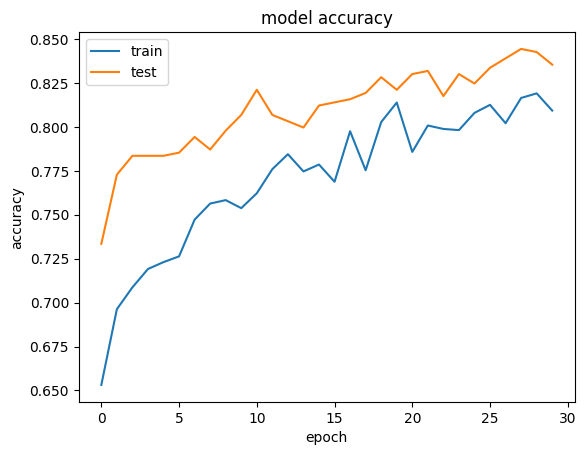

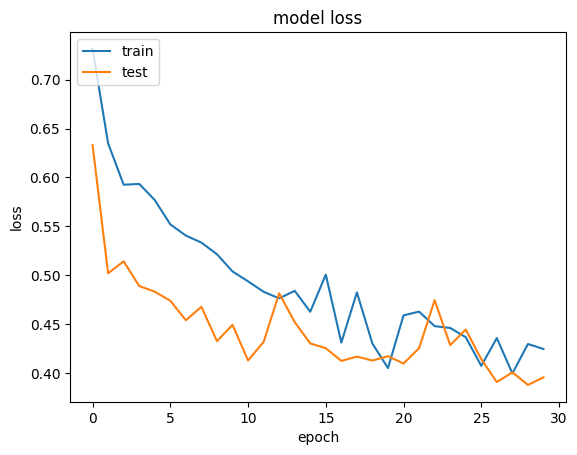

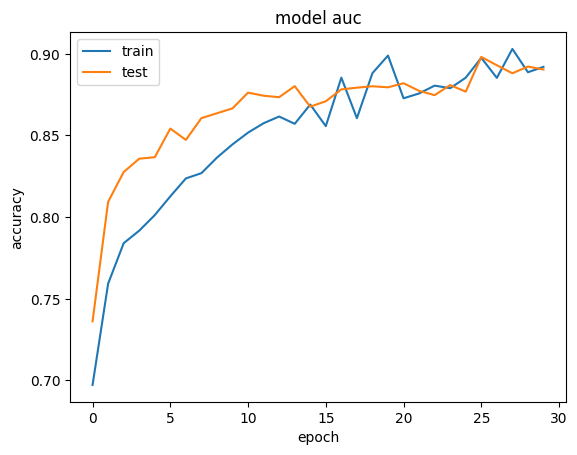

In [105]:
print(InceptionResNetV2_history.history.keys())
# summarize history for accuracy
plt.plot(InceptionResNetV2_history.history['accuracy'])
plt.plot(InceptionResNetV2_history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(InceptionResNetV2_history.history['loss'])
plt.plot(InceptionResNetV2_history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# summarize history for auc
plt.plot(InceptionResNetV2_history.history['auc_6'])
plt.plot(InceptionResNetV2_history.history['val_auc_6'])
plt.title('model auc')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [106]:
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, f1_score

y_pred = []
y_true = []

for i in range(len(val_generator)):
  images,labels = val_generator[i]
  ypreds = InceptionResNetV2_model.predict(images,verbose=0).squeeze(1)
  ypreds = np.round(ypreds)
  y_pred.extend(ypreds)
  y_true.extend(labels)


cm = confusion_matrix(y_true, y_pred)
print("Confusion matrix:\n", cm)
cr = classification_report(y_true, y_pred)
print("Classification report:\n", cr)
acc = accuracy_score(y_true, y_pred)
print("Accuracy:", acc)
f1 = f1_score(y_true, y_pred)
print("F1-score:", f1)

Confusion matrix:
 [[130  50]
 [ 42 337]]
Classification report:
               precision    recall  f1-score   support

         0.0       0.76      0.72      0.74       180
         1.0       0.87      0.89      0.88       379

    accuracy                           0.84       559
   macro avg       0.81      0.81      0.81       559
weighted avg       0.83      0.84      0.83       559

Accuracy: 0.8354203935599285
F1-score: 0.8798955613577022


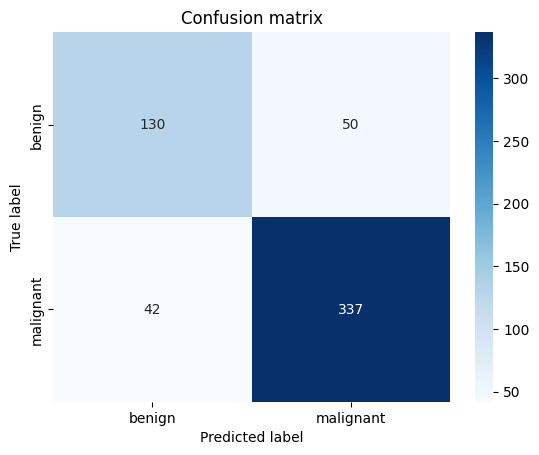

In [107]:
import seaborn as sns

# Plot the confusion matrix
sns.heatmap(cm, annot=True, cmap="Blues", fmt="d", xticklabels=['benign', 'malignant'], yticklabels=['benign', 'malignant'])
plt.title('Confusion matrix')
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()